# Esperimenti Online Learning - Progetto di Gruppo

Questo notebook contiene tutti gli esperimenti per il progetto di Online Learning, organizzati in modo modulare e scalabile.

## Importazioni e Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Importa i moduli customizzati
from environments import *
from agents import *
from data_generators import *
from utils import *

# Configurazione grafici
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Setup completato con successo!")


Setup completato con successo!


# Task 1.1: UCB1 per Pricing Semplice

Implementazione di UCB1 per il problema di pricing con valutazioni uniformi.

Task 1.1 - UCB1 Pricing Semplice
Prezzi: [0.1 0.2 0.3 0.5 0.7 0.8]
Ricavi attesi: [0.09 0.16 0.21 0.25 0.21 0.16]
Miglior prezzo chiarveggente: 0.5 (idx 3)


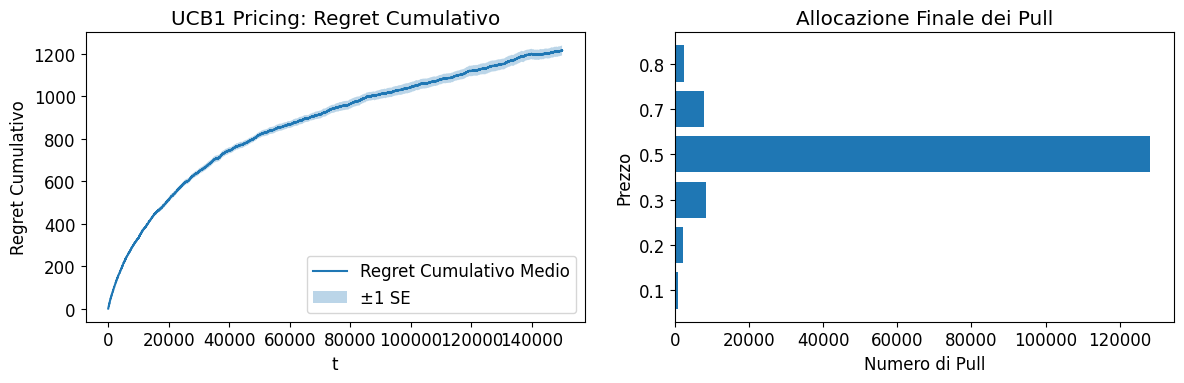


Risultati Finali Task 1.1:
Regret medio per round: 0.0081
Ricavi empirici medi: [0.09   0.1557 0.2093 0.249  0.208  0.1656]
Conteggi pull: [   800.   2088.   8384. 128192.   8000.   2536.]
Ricavi attesi reali: [0.09 0.16 0.21 0.25 0.21 0.16]


In [3]:
# Parametri per Task 1.1
prices = create_simple_prices()
T = 150_000
seed = 18
n_trials = 20

print("Task 1.1 - UCB1 Pricing Semplice")
print(f"Prezzi: {prices}")

# Soluzione chiarveggente
expected_revenues = prices * (1 - prices)
best_idx = np.argmax(expected_revenues)
best_price = prices[best_idx]

print(f"Ricavi attesi: {np.round(expected_revenues, 6)}")
print(f"Miglior prezzo chiarveggente: {best_price} (idx {best_idx})")

# Simulazione
np.random.seed(seed)
all_regrets = []

for trial in range(n_trials):
    rng = np.random.RandomState(seed + trial)
    env = PricingEnvironment(prices, T, rng=rng)
    agent = UCB1PricingAgent(len(prices), T)

    regrets = []
    cum_regret = 0.0
    
    for t in range(T):
        arm = agent.pull_arm()
        r = env.round(arm)
        agent.update(r)

        instant_regret = expected_revenues[best_idx] - r
        cum_regret += instant_regret
        regrets.append(cum_regret)

    all_regrets.append(regrets)

# Calcolo medie e plotting
all_regrets = np.array(all_regrets)
avg_regret = all_regrets.mean(axis=0)
sd_regret = all_regrets.std(axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(avg_regret, label="Regret Cumulativo Medio")
plt.fill_between(
    np.arange(T),
    avg_regret - sd_regret / np.sqrt(n_trials),
    avg_regret + sd_regret / np.sqrt(n_trials),
    alpha=0.3,
    label="±1 SE"
)
plt.xlabel("t")
plt.ylabel("Regret Cumulativo")
plt.title("UCB1 Pricing: Regret Cumulativo")
plt.legend()

plt.subplot(1, 2, 2)
labels = [f"{p:.1f}" for p in prices]
plt.barh(labels, agent.N_pulls)
plt.xlabel("Numero di Pull")
plt.ylabel("Prezzo")
plt.title("Allocazione Finale dei Pull")

plt.tight_layout()
plt.show()

print(f"\nRisultati Finali Task 1.1:")
print(f"Regret medio per round: {avg_regret[-1]/T:.4f}")
print(f"Ricavi empirici medi: {np.round(agent.average_rewards, 4)}")
print(f"Conteggi pull: {agent.N_pulls}")
print(f"Ricavi attesi reali: {np.round(expected_revenues, 4)}")


## Task 1.2: UCB Vincolato per Pricing con Budget

Implementazione di Constrained UCB per pricing con vincoli di budget.


Task 1.2 - UCB Vincolato per Pricing con Budget
Prezzi: 16 prezzi da 0.200 a 0.980
Budget: 4000, Orizzonte: 10000
Probabilità vendita (uniforme): primi 5 = [0.8   0.744 0.689 0.633 0.578]
Ricavi attesi: primi 5 = [0.16     0.190464 0.214279 0.232311 0.243916]
Utilità chiarveggente per round: 0.2395
Trial 1: Budget esaurito al round 8605.
Trial 2: Budget esaurito al round 8430.
Trial 3: Budget esaurito al round 8424.


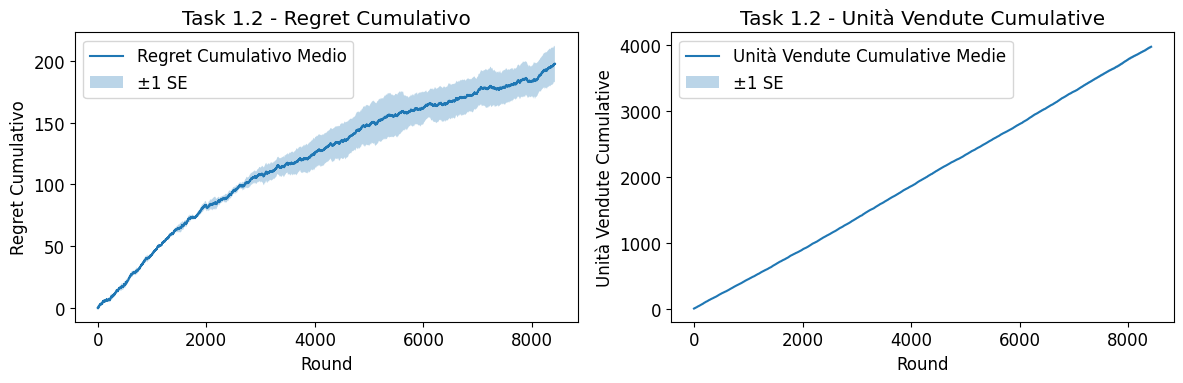


Risultati Finali:
Regret medio per round: 0.0235
Unità vendute cumulative medie: 3974.67
Ricavo cumulativo medio: 1831.79
Conteggi pull: [3.410e+02 4.130e+02 5.860e+02 6.800e+02 7.840e+02 1.066e+03 1.000e+03
 9.490e+02 7.620e+02 5.830e+02 4.530e+02 2.840e+02 2.450e+02 1.490e+02
 1.280e+02 1.000e+00]
Ricavo baseline: 2395.16


In [4]:
# Parametri per Task 1.2
prices = create_default_prices()
T = 10_000
B = 4_000
seed = 18
n_trials = 3

print("Task 1.2 - UCB Vincolato per Pricing con Budget")
print(f"Prezzi: {len(prices)} prezzi da {prices[0]:.3f} a {prices[-2]:.3f}")
print(f"Budget: {B}, Orizzonte: {T}")

# Probabilità di vendita e soluzione chiarveggente
sell_probabilities = np.maximum(0, 1-prices)
expected_reward = prices * sell_probabilities

print(f"Probabilità vendita (uniforme): primi 5 = {sell_probabilities[:5]}")
print(f"Ricavi attesi: primi 5 = {expected_reward[:5]}")

# Soluzione chiarveggente
exp_util, gamma, exp_cost = compute_clairvoyant_single_product(prices, sell_probabilities, B, T)
print(f"Utilità chiarveggente per round: {exp_util:.4f}")

# Simulazione
np.random.seed(seed)
all_regrets = []
all_units_sold = []
final_rewards = []

for trial in range(n_trials):
    rng = np.random.RandomState(seed + trial)
    env = BudgetedPricingEnvironment(prices, T, rng=rng)
    agent = ConstrainedUCBPricingAgent(len(prices), B, T, range=1)

    regrets = []
    units_sold = []
    cum_reward = 0.0
    cum_regret = 0.0
    cum_unit_sold = 0
    
    for t in range(T):
        arm = agent.pull_arm()
        if arm is None:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        reward, sold = env.round(arm)
        agent.update(reward, sold)

        cum_reward += reward
        instant_regret = exp_util - reward
        
        cum_regret += instant_regret
        cum_unit_sold += sold
        regrets.append(cum_regret)
        units_sold.append(cum_unit_sold)

    all_regrets.append(regrets)
    all_units_sold.append(units_sold)
    final_rewards.append(cum_reward)

# Plotting
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units_sold, n_trials, "Task 1.2 - ")
print_final_results(avg_regret, avg_units, min_rounds, final_rewards, agent)

baseline_reward = exp_util * T
print(f"Ricavo baseline: {baseline_reward:.2f}")


## Task 2.1: UCB Combinatoriale per Multi-Prodotto

Implementazione di Constrained Combinatorial UCB per pricing multi-prodotto con budget condiviso.


In [ ]:
# Parametri per Task 2.1
N_products = 3
base_prices = np.array([0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.70, 0.80, 0.85, 0.90, 0.95, 0.98])
dummy_price = 1.001
price_grid = create_multiproduct_price_grid(
    np.concatenate([base_prices, [dummy_price]]), N_products
)

T = 100_000
B = 20_000
seed = 18
n_trials = 2

print(f"Task 2.1 - UCB Combinatoriale Multi-Prodotto")
print(f"Prodotti: {N_products}, Prezzi per prodotto: {len(price_grid[0])}")
print(f"Budget: {B}, Orizzonte: {T}")

# Calcolo soluzione chiarveggente
# Genera valutazioni demo per calcolare baseline
V_demo = np.random.uniform(0, 1, size=(T, N_products))
exp_util, gamma, exp_cost = compute_extended_clairvoyant(V_demo, price_grid[0], B)

print(f"Ricavo chiarveggente per round: {exp_util:.4f}")
print(f"Costo atteso per round: {exp_cost:.4f}")
print(f"Gamma ottimale (primi 5): {gamma[:, :5]}")

# Simulazione
all_regrets = []
all_units = []
final_rewards = []

for trial in range(n_trials):
    print(f"Trial {trial+1}/{n_trials}...")
    rng = np.random.default_rng(seed + trial)
    env = MultiProductPricingEnvironment(price_grid, T, rng=rng)
    agent = ConstrainedCombinatorialUCBAgent(price_grid, B, T)

    cum_regret, cum_units = 0.0, 0
    regrets, units = [], []

    for t in range(T):
        choice = agent.pull_arm()
        if choice is None:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        rewards, costs = env.round(choice)
        agent.update(rewards, costs)

        actual_rew = rewards.sum()
        actual_units = costs.sum()
        cum_regret += (exp_util - actual_rew)
        cum_units += actual_units
        regrets.append(cum_regret)
        units.append(cum_units)

    all_regrets.append(regrets)
    all_units.append(units)
    final_rewards.append(actual_rew)  # Ricavo ultimo round

# Plotting
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units, n_trials, "Task 2.1 - ")

print(f"\nRisultati Finali Task 2.1:")
print(f"Regret medio per round: {avg_regret[-1]/min_rounds:.4f}")
print(f"Unità vendute cumulative medie: {avg_units[-1]:.2f}")
print(f"Budget utilizzato medio: {avg_units[-1]}/{B} ({100*avg_units[-1]/B:.1f}%)")

# Stampa statistiche per prodotto se disponibili
if hasattr(agent, 'N_pulls'):
    for j in range(N_products):
        print(f"Prodotto {j+1} - Pull counts: {agent.N_pulls[j][:5]}... (primi 5 prezzi)")


Task 2.1 - UCB Combinatoriale Multi-Prodotto
Prodotti: 3, Prezzi per prodotto: 13
Budget: 20000, Orizzonte: 100000
Ricavo chiarveggente per round: 0.1851
Costo atteso per round: 0.2000
Gamma ottimale (primi 5): [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Trial 1/2...


## Task 3.1: Primal-Dual per Pricing Non-Stazionario

Implementazione di Full-Feedback Primal-Dual per ambienti non-stazionari con shock avversariali.


In [ ]:
# Parametri per Task 3.1
prices = create_default_prices()
T = 80_000
B = 20_000
seed = 17
shock_prob = 0.50
freq = 100
n_trials = 3

print(f"Task 3.1 - Primal-Dual per Pricing Non-Stazionario")
print(f"Budget: {B}, Orizzonte: {T}")
print(f"Probabilità shock: {shock_prob}, Frequenza: {freq}")
print(f"Prezzi: {len(prices)} da {prices[0]:.3f} a {prices[-2]:.3f}")

# Simulazione
all_regrets = []
all_units_sold = []
final_rewards = []

for trial in range(n_trials):
    print(f"\nTrial {trial+1}/{n_trials}...")
    rng = np.random.RandomState(seed + trial)
    
    # Crea ambiente non-stazionario
    env = NonStationaryBudgetedPricingEnvironment(
        prices, T, shock_prob, freq, num_regimes=10000, 
        valuation_type='piecewise_beta', rng=rng
    )
    
    # Calcola soluzione chiarveggente per questo trial
    sell_probabilities = env.compute_sell_probabilities()
    exp_util, gamma, exp_cost = compute_clairvoyant_single_product(
        prices, sell_probabilities, B, T
    )
    
    if trial == 0:
        print(f"Utilità chiarveggente: {exp_util:.4f}")
        print(f"Costo atteso per round: {exp_cost:.4f}")
        print(f"Probabilità vendita (primi 5): {sell_probabilities[:5]}")
    
    # Crea agente Primal-Dual
    agent = FFPrimalDualPricingAgent(prices, T, B, rng=rng, eta=1/np.sqrt(T))

    regrets = []
    units_sold = []
    cum_reward = 0.0
    cum_regret = 0.0
    cum_unit_sold = 0
    
    for t in range(T):
        arm = agent.pull_arm()
        if arm is None:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        # Full feedback: ottieni la valutazione
        valuation = env.full_feedback_round()
        reward, sold = agent.update(valuation)

        cum_reward += reward
        instant_regret = exp_util - reward
        
        cum_regret += instant_regret
        cum_unit_sold += sold
        regrets.append(cum_regret)
        units_sold.append(cum_unit_sold)

    all_regrets.append(regrets)
    all_units_sold.append(units_sold)
    final_rewards.append(cum_reward)
    
    print(f"Trial {trial+1}: Ricavo finale = {cum_reward:.2f}, Budget rimanente = {agent.inventory}")

# Plotting e risultati
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units_sold, n_trials, "Task 3.1 - ")

print(f"\nRisultati Finali Task 3.1:")
print(f"Regret medio per round: {avg_regret[-1]/min_rounds:.4f}")
print(f"Unità vendute cumulative medie: {avg_units[-1]:.2f}")

if final_rewards:
    final_rewards = np.array(final_rewards)
    print(f"Ricavo cumulativo medio: {np.mean(final_rewards):.2f}")

# Statistiche sull'agente
print(f"Pull counts finali: {agent.pull_counts}")
print(f"Moltiplicatore λ finale: {agent.lmbd:.4f}")

baseline_reward = exp_util * T
print(f"Ricavo baseline chiarveggente: {baseline_reward:.2f}")
print(f"Efficienza media: {100*np.mean(final_rewards)/baseline_reward:.1f}%")


## Task 4.1: Multi-Product Primal-Dual

Implementazione di Multi-Product Full-Feedback Primal-Dual per ambienti correlati multi-prodotto.


In [ ]:
# Parametri per Task 4.1
T = 200_000
m = 4  # numero di prodotti
B = 80_000
seed = 42
n_trials = 2

# Prezzi: braccio dummy > 1 per rappresentare "non vendere"
prices = np.array([0.2, 0.256, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.1])

# Parametri per generazione valutazioni multivariate
mu0, A, f = 0.5, 0.1, 100
phi = np.zeros(m)
sigma0, A_sigma, phi_sigma, rho0 = 0.1, 0.1, 0, 0.6

print(f"Task 4.1 - Multi-Product Primal-Dual")
print(f"Prodotti: {m}, Budget: {B}, Orizzonte: {T}")
print(f"Prezzi: {len(prices)} da {prices[0]:.3f} a {prices[-2]:.3f}")
print(f"Parametri correlazione: μ₀={mu0}, ρ₀={rho0}")

# Simulazione
all_regrets = []
all_units_sold = []
final_rewards = []

for trial in range(n_trials):
    print(f"\nTrial {trial+1}/{n_trials}...")
    trial_rng = np.random.default_rng(seed + trial)
    
    # Genera valutazioni piecewise-stazionarie per questo trial
    V, _ = generate_piecewise_tv_mv_gauss(T, m, num_regimes=10000, rng=trial_rng)
    
    # Calcola soluzione chiarveggente
    exp_util, gamma, exp_cost = compute_extended_clairvoyant(V, prices, B)
    
    if trial == 0:
        print(f"Ricavo chiarveggente per round: {exp_util:.4f}")
        print(f"Costo atteso per round: {exp_cost:.4f}")
        print(f"Gamma ottimale shape: {gamma.shape}")
        print(f"Media gamma per prodotto: {gamma.mean(axis=1)}")
    
    # Crea ambiente con valutazioni pre-generate
    valuation_params = {
        'mu0': mu0, 'A': A, 'f': f, 'phi': phi,
        'sigma0': sigma0, 'A_sigma': A_sigma, 'phi_sigma': phi_sigma, 'rho0': rho0,
        'num_regimes': 10000
    }
    
    env = MultiProductBudgetedPricingEnvironment(
        prices, T, m, valuation_params, valuation_type='piecewise_tv', rng=trial_rng
    )
    # Sostituisci con le valutazioni calcolate
    env.V = V
    
    # Crea agente Multi-Product Primal-Dual
    eta = 1 / np.sqrt(T)
    agent = MultiProductFFPrimalDualPricingAgent(prices, T, B, m, trial_rng, eta)
    
    regrets = []
    units_sold = []
    cum_reward = 0.0
    cum_regret = 0.0
    cum_units = 0
    
    for t in range(T):
        if agent.inventory < 1:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        # Full feedback: ottieni valutazioni per tutti i prodotti
        v_t = env.full_feedback_round()
        reward, sold = agent.update(v_t)
        
        cum_reward += reward
        instant_regret = exp_util - reward
        cum_regret += instant_regret
        cum_units += sold
        regrets.append(cum_regret)
        units_sold.append(cum_units)
    
    all_regrets.append(regrets)
    all_units_sold.append(units_sold)
    final_rewards.append(cum_reward)
    
    print(f"Trial {trial+1}: Ricavo cumulativo finale = {cum_reward:.2f}")
    print(f"Trial {trial+1}: Budget rimanente = {agent.inventory}")
    print(f"Trial {trial+1}: λ finale = {agent.lmbd:.4f}")

# Plotting e risultati
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units_sold, n_trials, "Task 4.1 - ")

print(f"\nRisultati Finali Task 4.1:")
print(f"Regret medio per round: {avg_regret[-1]/min_rounds:.4f}")
print(f"Unità vendute cumulative medie: {avg_units[-1]:.2f}")
print(f"Ricavo cumulativo medio finale: {np.mean(final_rewards):.2f}")

# Debug: analisi per prodotto dell'ultimo agente
if hasattr(agent, 'debug_chosen_prices'):
    print(f"\nAnalisi Multi-Prodotto (ultimo trial):")
    for j in range(m):
        chosen_prices = [p for p in agent.debug_chosen_prices[j] if p is not None]
        sold_prices = [p for p in agent.debug_sold_prices[j] if p is not None]
        
        if chosen_prices:
            print(f"Prodotto {j+1}:")
            print(f"  - Prezzi scelti: {len(chosen_prices)} volte")
            print(f"  - Prezzi venduti: {len(sold_prices)} volte")
            print(f"  - Prezzo medio scelto: {np.mean(chosen_prices):.3f}")
            if sold_prices:
                print(f"  - Prezzo medio venduto: {np.mean(sold_prices):.3f}")
                print(f"  - Tasso di conversione: {100*len(sold_prices)/len(chosen_prices):.1f}%")

baseline_total = exp_util * min_rounds
efficiency = 100 * np.mean(final_rewards) / baseline_total
print(f"\nEfficienza complessiva: {efficiency:.1f}%")


## Task 5.1: Sliding Window per Non-Stazionarietà

Implementazione di Constrained Combinatorial UCB con Sliding Window per adattamento locale a cambiamenti.


In [ ]:
# Parametri per Task 5.1
N_products = 2
base_prices = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
dummy_price = 1.001
price_grid = create_multiproduct_price_grid(
    np.concatenate([base_prices, [dummy_price]]), N_products
)

T = 50_000
B = 20_000
num_windows = 5  # Numero di finestre di cambiamento
window_size = 1000  # Dimensione della sliding window
seed = 18
n_trials = 2

print(f"Task 5.1 - Sliding Window per Non-Stazionarietà")
print(f"Prodotti: {N_products}, Finestre temporali: {num_windows}")
print(f"Dimensione sliding window: {window_size}")
print(f"Budget: {B}, Orizzonte: {T}")
print(f"Prezzi per prodotto: {len(price_grid[0])}")

# Simulazione
all_regrets = []
all_units_sold = []
final_rewards = []

for trial in range(n_trials):
    print(f"\nTrial {trial+1}/{n_trials}...")
    rng = np.random.default_rng(seed + trial)
    
    # Crea ambiente con cambiamenti piecewise
    env = SlidingWindowMultiProductEnvironment(price_grid, T, num_windows, rng=rng)
    
    # Crea agente con sliding window
    agent = SlidingWindowConstrainedCombinatorialUCBAgent(
        price_grid, B, T, alpha=1, window_size=window_size
    )

    regrets = []
    units_sold = []
    cum_reward = 0.0
    cum_regret = 0.0
    cum_units = 0
    
    # Baseline semplificato: ricavo medio atteso per il tipo di ambiente
    # In un ambiente reale, questo verrebbe calcolato con il chiarveggente completo
    baseline_revenue_per_round = 0.25  # Da calibrare empiricamente
    
    # Traccia la performance in ogni finestra
    window_length = T // num_windows
    window_performance = []
    current_window_start = 0
    
    for t in range(T):
        choice = agent.pull_arm()
        if choice is None:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        rewards, costs = env.round(choice)
        agent.update(rewards, costs)

        actual_rew = rewards.sum()
        actual_units = costs.sum()
        cum_reward += actual_rew
        
        # Calcola regret istantaneo
        instant_regret = baseline_revenue_per_round - actual_rew
        cum_regret += instant_regret
        cum_units += actual_units
        regrets.append(cum_regret)
        units_sold.append(cum_units)
        
        # Traccia performance per finestra
        if t > 0 and t % window_length == 0:
            window_id = (t // window_length) - 1
            window_avg_reward = cum_reward / t
            window_performance.append(window_avg_reward)
            if trial == 0:  # Stampa solo per il primo trial
                print(f"  Finestra {window_id+1}: Ricavo medio = {window_avg_reward:.4f}")

    all_regrets.append(regrets)
    all_units_sold.append(units_sold)
    final_rewards.append(cum_reward)
    
    print(f"Trial {trial+1}: Ricavo finale = {cum_reward:.2f}")
    print(f"Trial {trial+1}: Budget utilizzato = {cum_units}/{B} ({100*cum_units/B:.1f}%)")

# Plotting e risultati
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units_sold, n_trials, "Task 5.1 - ")

print(f"\nRisultati Finali Task 5.1:")
print(f"Regret medio per round: {avg_regret[-1]/min_rounds:.4f}")
print(f"Unità vendute cumulative medie: {avg_units[-1]:.2f}")
print(f"Ricavo cumulativo medio: {np.mean(final_rewards):.2f}")

# Analisi dell'adattamento
if hasattr(agent, 'samples'):
    print(f"\nAnalisi Adattamento Sliding Window:")
    for j in range(N_products):
        total_samples = sum(len(agent.samples[j][k]) for k in range(len(agent.samples[j])))
        active_prices = sum(1 for k in range(len(agent.samples[j])) if len(agent.samples[j][k]) > 0)
        print(f"Prodotto {j+1}:")
        print(f"  - Campioni totali nella finestra: {total_samples}")
        print(f"  - Prezzi attivi nella finestra: {active_prices}/{len(agent.samples[j])}")

# Confronto performance
baseline_total = baseline_revenue_per_round * min_rounds
efficiency = 100 * np.mean(final_rewards) / baseline_total
print(f"\nEfficienza vs baseline semplificato: {efficiency:.1f}%")

print(f"\n⚠️  Nota: Task 5.1 usa un baseline semplificato.")
print(f"Per risultati più precisi, implementare calcolo chiarveggente")
print(f"specifico per l'ambiente sliding window con cambiamenti piecewise.")
